In [27]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [28]:
# Covid-19 SG dataset details

sheet_id = "1gFTNs_GtnTIyyVWXmsQxwdZpGbyicZM2HJcXvCf4b3k"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

In [29]:
# read Covid-19 SG dataset

sg_data = pd.read_csv(url)

In [30]:
# filter to include only columns A to AD

sg_data_filtered = sg_data.iloc[:, :30]

# EDA & Pre-processing

**Outliers will not be removed because of their importance in the Covid context.**

**No need for scaling as all features are of the same magnitude.**

**Can look into what other features can be included from the current ones through extrapolation.**

In [31]:
sg_data_filtered.head()

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,...,Total Hospital Discharged MOH report,Requires Oxygen Supplementation,Linked community cases,Unlinked community cases,Phase,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination
0,2020-01-23,1,NaN,1,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-24,2,NaN,3,0,0,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-25,1,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-26,0,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-27,1,NaN,5,0,0,0,0,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643 entries, 0 to 642
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Date                                          643 non-null    object 
 1   Daily Confirmed                               643 non-null    int64  
 2   False Positives Found                         534 non-null    float64
 3   Cumulative Confirmed                          643 non-null    int64  
 4   Daily Discharged                              643 non-null    int64  
 5   Passed but not due to COVID                   643 non-null    int64  
 6   Cumulative Discharged                         643 non-null    int64  
 7   Discharged to Isolation                       643 non-null    int64  
 8   Still Hospitalised                            643 non-null    int64  
 9   Daily Deaths                                  643 non-null    int

In [33]:
# convert date to columns: year, month, day before dropping date column

sg_data_filtered["Date"] = pd.to_datetime(sg_data_filtered["Date"])
sg_data_filtered["Year"] = sg_data_filtered["Date"].dt.year
sg_data_filtered["Month"] = sg_data_filtered["Date"].dt.month
sg_data_filtered["Day"] = sg_data_filtered["Date"].dt.day
sg_data_filtered.drop("Date", axis=1, inplace=True)

In [34]:
# convert NaN values for phase to None

sg_data_filtered["Phase"] = sg_data_filtered["Phase"].fillna("None")

In [35]:
# change to one-hot dummy for phase

sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1).drop('Phase', axis = 1)

In [36]:
# convert percentage for Perc population completed at least one dose & Perc population completed vaccination

sg_data_filtered["Perc population completed at least one dose"] = [int(perc.split("%")[0]) if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed at least one dose"]]
sg_data_filtered["Perc population completed vaccination"] = [int(perc.split("%")[0]) if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed vaccination"]]

In [37]:
# convert all NaN values present to zeros for the rest of the columns (if data is unavailable, just treat as 0)

sg_data_filtered.fillna(0, inplace=True)

In [38]:
# check to see if NaN values still present

sg_data_filtered.isnull().values.any()

False

In [39]:
# check column info after pre-processing

sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643 entries, 0 to 642
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Daily Confirmed                               643 non-null    int64  
 1   False Positives Found                         643 non-null    float64
 2   Cumulative Confirmed                          643 non-null    int64  
 3   Daily Discharged                              643 non-null    int64  
 4   Passed but not due to COVID                   643 non-null    int64  
 5   Cumulative Discharged                         643 non-null    int64  
 6   Discharged to Isolation                       643 non-null    int64  
 7   Still Hospitalised                            643 non-null    int64  
 8   Daily Deaths                                  643 non-null    int64  
 9   Cumulative Deaths                             643 non-null    int

<AxesSubplot:>

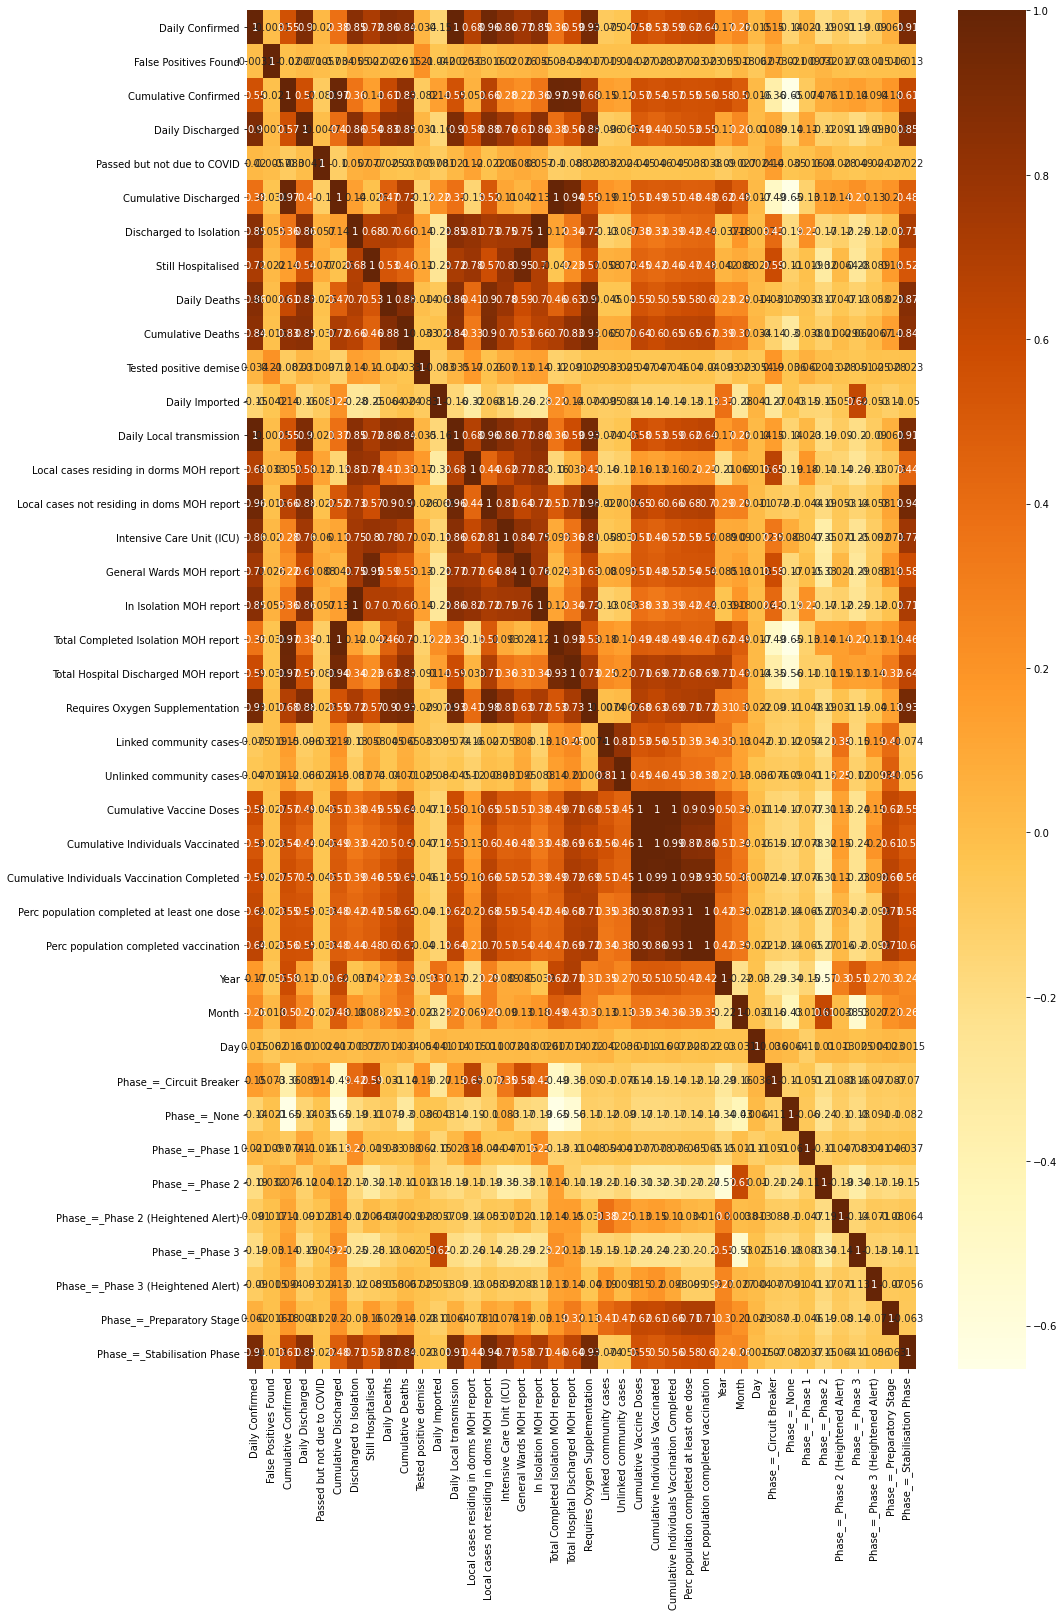

In [40]:
# corr. heatmap

plt.figure(figsize=(15,25))
sns.heatmap(sg_data_filtered.corr(), cmap='YlOrBr', annot=True)

In [41]:
# understanding correlation of all variables to imported cases (can change accordingly to the variable you are trying to predict)

sg_data_filtered.corr()["Perc population completed vaccination"].sort_values(ascending=False)

Perc population completed vaccination           1.000000
Perc population completed at least one dose     0.998858
Cumulative Individuals Vaccination Completed    0.930612
Cumulative Vaccine Doses                        0.901226
Cumulative Individuals Vaccinated               0.863885
Requires Oxygen Supplementation                 0.723461
Phase_=_Preparatory Stage                       0.708096
Local cases not residing in doms MOH report     0.700497
Total Hospital Discharged MOH report            0.692931
Cumulative Deaths                               0.667837
Daily Local transmission                        0.639644
Daily Confirmed                                 0.639189
Phase_=_Stabilisation Phase                     0.600221
Daily Deaths                                    0.595285
Intensive Care Unit (ICU)                       0.566708
Cumulative Confirmed                            0.559407
Daily Discharged                                0.549132
General Wards MOH report       

In [42]:
# conduct PCA on preprocessed columns

# pca = PCA().fit(sg_data_filtered)

In [43]:
# pca.components_[0]

In [44]:
# find index of columns that make most contribution to variance captured

# include index of Daily Imported first
# important_indices = [11]

# for i in range(len(pca.components_[0])):
#     curr_comp = pca.components_[0][i]
#     if curr_comp > 0.0001:
#         important_indices.append(i)

In [45]:
# select the columns that are positively correlated to imported cases + PCA columns

# sg_data_final = sg_data_filtered.iloc[:, important_indices]

# Train Test Split & K Fold Cross Validation

In [46]:
# change y variable accordingly to what is of interest

X = sg_data_filtered.drop("Perc population completed vaccination", axis=1)
y = sg_data_filtered["Perc population completed vaccination"]
y

0       0
1       0
2       0
3       0
4       0
       ..
638    84
639    84
640    84
641    84
642    84
Name: Perc population completed vaccination, Length: 643, dtype: int64

In [47]:
# split using 25% for test as amount of data isn't much so that we've got more points to test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [48]:
strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Linear Regression

In [49]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [50]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=strat_k_fold)), 4)}")

Evaluation Metrics for LR
MAE: 0.24328003106368087
MSE: 0.14626046712144297
RMSE: 0.38244014841729546
R-squared score for train: 0.9998481214975411
Adjusted R-squared score for train: 0.9998382985098199
R-squared score for test: 0.9998553106688937
Adjusted R-squared score for test: 0.9998459526524539
Cross Validation Score: 0.9998


C:\Users\Zeph Ng\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


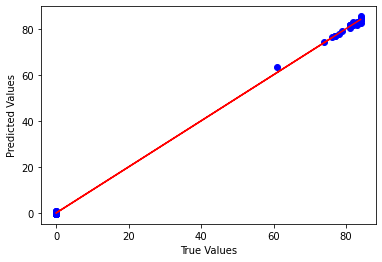

In [51]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

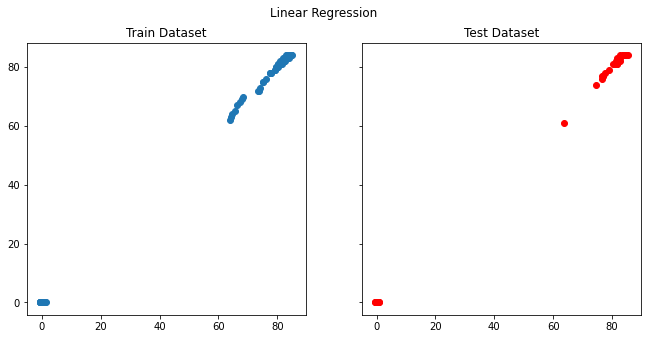

In [52]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [53]:
# find out feature importance

regr_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': regression.coef_
})

regr_importance = regr_importance.sort_values(by='Importance', ascending=False)
regr_importance

,Attribute,Importance
11,Daily Imported,4.906926e+06
12,Daily Local transmission,4.906926e+06
37,Phase_=_Preparatory Stage,2.707615e+00
26,Perc population completed at least one dose,8.020440e-01
38,Phase_=_Stabilisation Phase,6.721056e-01
2,Cumulative Confirmed,5.371527e-02
10,Tested positive demise,1.637215e-02
1,False Positives Found,7.876625e-03
19,Total Hospital Discharged MOH report,4.405962e-03
22,Unlinked community cases,3.405670e-03


# Ridge Regression

In [54]:
# build lasso model

ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

C:\Users\Zeph Ng\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.02099e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [55]:
# assessing model

train_adjusted_r2 = 1 - (1-ridge.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-ridge.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}")
print(f"R-squared score for train: {ridge.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {ridge.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=strat_k_fold)), 4)}")

Evaluation Metrics for Ridge
MAE: 0.24938595307976807
MSE: 0.15293420322730888
RMSE: 0.39106802889946
R-squared score for train: 0.9998197916348313
Adjusted R-squared score for train: 0.9998081363674323
R-squared score for test: 0.9998487086223383
Adjusted R-squared score for test: 0.9998389236078626
Cross Validation Score: 0.9998


C:\Users\Zeph Ng\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Zeph Ng\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.76238e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Zeph Ng\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.71417e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Zeph Ng\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.66551e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Zeph Ng\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=

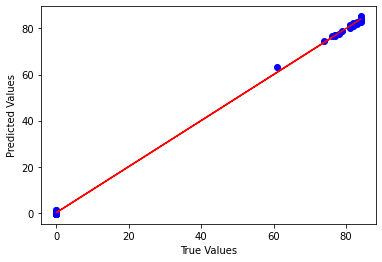

In [56]:
# For test set

# scatter for predictions
plt.scatter(y_test, ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

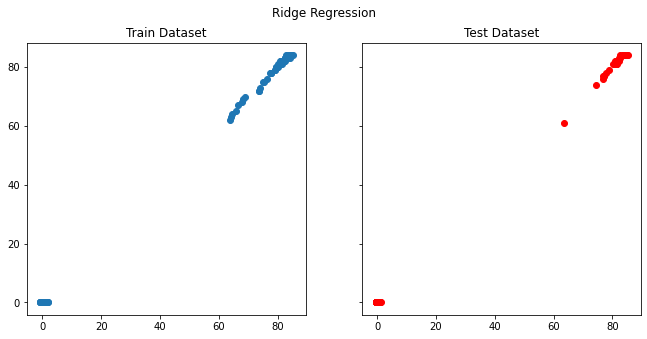

In [57]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(ridge.predict(X_train), y_train)
ax[1].scatter(ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

In [58]:
# find out feature importance

ridge_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': ridge.coef_
})

ridge_importance = ridge_importance.sort_values(by='Importance', ascending=False)
ridge_importance

,Attribute,Importance
37,Phase_=_Preparatory Stage,2.074616
26,Perc population completed at least one dose,0.789731
2,Cumulative Confirmed,0.149811
33,Phase_=_Phase 2,0.043782
36,Phase_=_Phase 3 (Heightened Alert),0.013233
1,False Positives Found,0.007929
22,Unlinked community cases,0.003347
0,Daily Confirmed,0.002817
11,Daily Imported,0.002572
19,Total Hospital Discharged MOH report,0.002435
